In [1]:
import theano
import theano.tensor as T
import lasagne as L

from theano.printing import Print as TPP

import time
from IPython import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Using gpu device 0: Tesla K40m (CNMeM is disabled, cuDNN 4007)


In [2]:
%run ../ntm_bfgs_optimizer.py

In [3]:
class RosenbrockFunction:
    def __init__(self, theta=None, a=None, b=None):
        self.a = a or T.scalar('a')
        self.b = b or T.scalar('b')

        self.theta = theta or T.vector('theta')
        
        self.func = (self.a - self.theta[0])**2 + self.b * (theta[1] - theta[0]**2)**2
        self.grad = theano.grad(self.func, self.theta)
        
        self.params = [self.a, self.b]

In [4]:
A = T.scalar()
B = T.scalar()
    
func = lambda theta: RosenbrockFunction(theta, A, B).func

In [5]:
input_var = T.vector()

In [6]:
def sgd_step(theta, lr):
    f = func(theta)
    g = theano.grad(f, theta)
    return theta - lr * g, f

n_steps = T.iscalar()

sgd_lr = T.scalar()
sgd_thetas, sgd_losses = theano.scan(fn=sgd_step,
                                        outputs_info=[input_var, None],
                                                      non_sequences=sgd_lr,
                                                      n_steps=n_steps)[0]

sgd_fn = theano.function([input_var, n_steps, A, B, sgd_lr], [sgd_thetas, sgd_losses], allow_input_downcast=True)

In [7]:
def momentum_step(theta, old_grad, lr, mu):
    f = func(theta)
    g = theano.grad(f, theta)
    new_grad = mu * old_grad + g
    return theta - lr * new_grad, f, new_grad

momentum_steps = T.iscalar()
momentum_mu = T.scalar()

momentum_thetas, momentum_losses, _ = theano.scan(fn=momentum_step,
                                                  outputs_info=[input_var, None, T.zeros_like(input_var)],
                                                  non_sequences=[sgd_lr, momentum_mu],
                                                  n_steps=n_steps)[0]

momentum_fn = theano.function([input_var, n_steps, A, B, sgd_lr], [momentum_thetas, momentum_losses], allow_input_downcast=True, givens={
        momentum_mu: np.cast['float32'](0.9),
    })

In [8]:
lstm_optimizers = {}

options = {
    'num_units': 20,
    'function': func,
    'n_layers': 2,
    'preprocess_input': False,
    'gradient_steps': 20,    
    'input_var': input_var,
    'memdot': True,
}

for n_gac in [0, 5]: #for n_gac in [0, 5]:
    for loglr in [True]:#for loglr in [False, True]:
        options['n_gac'] = n_gac
        options['loglr'] = loglr
        
        key = "n_gac={}; loglr={}".format(n_gac, loglr)
        if options.get(key, None) is None:
            lstm_optimizers[key] = NTM_BFGS_Optimizer(**options)
            print(key)

n_gac=0; loglr=True
n_gac=5; loglr=True


In [ ]:
def sample_point(ndim=2):
    return np.zeros(2)

def sample_params(ndim=None):
    a = np.random.uniform(low=-3, high=3)
    b = np.random.uniform(20, 100)
    return a, b

def sample_point_and_params(ndim=None):
    a, b = sample_params(ndim)
    theta = sample_point(ndim)
    
    return theta, (a, b)

In [ ]:
training_options = {
    'n_epochs': 30,
    'batch_size': 200,
    'decay_rate': 0.99,
    'verbose': True
}

optimizer_losses = {}

for key, opt in lstm_optimizers.items():
    opt.prepare([A, B], loss_type='sum', start_lr=0.005)
    print(key)

    sampler = sample_point_and_params
    
    optimizer_losses[key] = []
    
    for n_iter in [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]:
        training_options['n_iter'] = n_iter
#         opt.lr.set_value(0.005)
        optimizer_losses[key] += opt.train(sampler, **training_options)
        
#         display.clear_output(wait=True)
#         opt_loss = np.array(optimizer_loss)
#         opt_loss = opt_loss[opt_loss < 10000]
#         plt.plot(optimizer_loss)

Time compiling loss_fn: 2.055267095565796
Epoch number 11
	Time: 134.58431792259216
	Optimizer loss: 216.89324951171875
	Median final loss: 2.153052806854248
Epoch number 12
	Time: 134.5156590938568
	Optimizer loss: 917.7520751953125
	Median final loss: 2.2212448120117188
Epoch number 13
	Time: 134.03549814224243
	Optimizer loss: 1422.5526123046875
	Median final loss: 2.3853564262390137
Epoch number 14
	Time: 134.7147557735443
	Optimizer loss: 157.8856201171875
	Median final loss: 1.7824461460113525
Epoch number 15
	Time: 134.96599316596985
	Optimizer loss: 662.7805786132812
	Median final loss: 2.4866647720336914
Epoch number 16
	Time: 135.02474236488342
	Optimizer loss: 1052.949462890625
	Median final loss: 2.1193742752075195
Epoch number 17
	Time: 107.07018637657166
	Optimizer loss: 852.1515502929688
	Median final loss: 2.1293187141418457


KeyboardInterrupt: 

In [13]:
def get_moving_loss(loss):
    moving_loss = [loss[0]]
    for i in loss[1:]:
        moving_loss.append(0.9 * moving_loss[-1] + 0.1 * i)
    return moving_loss

/home/vyanush/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 60000 but corresponding boolean dimension is 42000
  from ipykernel import kernelapp as app


inf


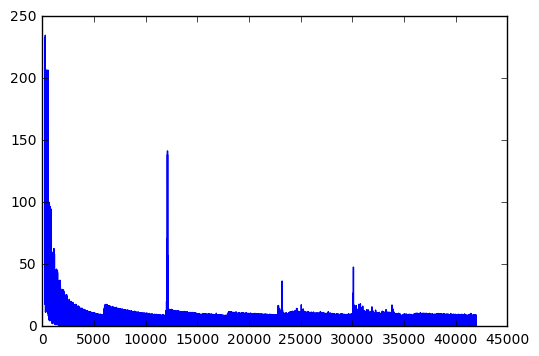

In [45]:
opt_loss = np.array(list(optimizer_losses.values())[0])
opt_loss = opt_loss[opt_loss < 10000] / (20. * np.arange(60000)[opt_loss < 10000] / 6000).astype(int)
plt.plot(opt_loss)
print(opt_loss.max())
# moving_loss = [optimizer_loss[-1]]
# for i in optimizer_loss[1:]:
#     moving_loss.append(0.9 * moving_loss[-1] + 0.1 * i)
# plt.plot(moving_loss)

3.71462879587
3.27304055911
3.13184641106
3.77625694649
4.14896421337


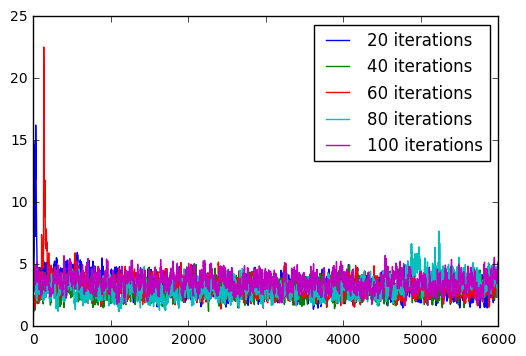

In [44]:
opt_loss = np.array(list(optimizer_losses.values())[0])
for i in range(5):
    cur = opt_loss[i * 6000: (i + 1) * 6000] / (20 * (i + 1))
    cur = cur[cur < 100]
    cur = get_moving_loss(cur)
    print(cur[-1])
    plt.plot(cur, label='{} iterations'.format(20 * (i + 1)))
plt.legend()

In [23]:
non_lstm_optimizers = {
    'momentum': momentum_fn
}

In [ ]:
# for name, opt in lstm_optimizers.items():
#     with open('quadratic_optimizer_drop_coord_low_dim({}).npz'.format(name), 'wb') as f:
#         np.savez(f, L.layers.get_all_param_values(opt.l_optim))

In [ ]:
# for name, opt in lstm_optimizers.items():
#     with np.load('quadratic_optimizer_drop_coord_low_dim({}).npz'.format(name)) as f:
#         param_values = [f['arr_%d' % i] for i in range(len(f.files))]
#     L.layers.set_all_param_values(opt.l_optim, param_values[0])

In [31]:
def test_optimizers(**testing_options):
    thetas_and_params = [testing_options['sampler']() for _ in range(testing_options['n_functions'])]
    
    histories = {}
    
    for key, opt in lstm_optimizers.items():
        print("Testing lstm; {key}".format(**locals()))
        loss_history = [] 
        for theta, (W_, b_) in thetas_and_params:
            loss_history.append(opt.optimize(theta, [W_, b_], testing_options['n_iter'])[1])
            
        histories['lstm; {}'.format(key)] = np.median(loss_history, axis=0)

    lrates = np.logspace(0, 29, num=30, base=2.0) * 1e-6
    
    for name, opt in non_lstm_optimizers.items():
        best_lrate = None
        best_loss = None
        best_history = None

        print("Testing {name}".format(**locals()))
        
        for lrate in lrates:
            loss_history = [] 
            for theta, (W_, b_) in thetas_and_params:
                loss_history.append(opt(theta, testing_options['n_iter'], W_, b_, lrate)[1])
            
            if np.isnan(loss_history).any():
                break
            
            loss = np.median(loss_history, axis=0)[-1]
            if best_loss is None or best_loss > loss:
                best_loss = loss
                best_lrate = lrate
                best_history = np.median(loss_history, axis=0)
                
        histories["{name}; lr={best_lrate}".format(**locals())] = best_history
    return histories

In [32]:
testing_options = {
    'n_iter': 60,
    'n_functions': 50,
    'sampler': sample_point_and_params
}

histories_60 = test_optimizers(**testing_options)

Testing lstm; n_gac=0; loglr=True
Testing momentum


In [33]:
testing_options = {
    'n_iter': 500,
    'n_functions': 50,
    'sampler': sample_point_and_params
}

histories_500 = test_optimizers(**testing_options)

Testing lstm; n_gac=0; loglr=True
Testing momentum


In [34]:
testing_options = {
    'n_iter': 500,
    'n_functions': 1,
    'sampler': sample_point_and_params
}

histories_1_func = test_optimizers(**testing_options)

Testing lstm; n_gac=0; loglr=True
Testing momentum


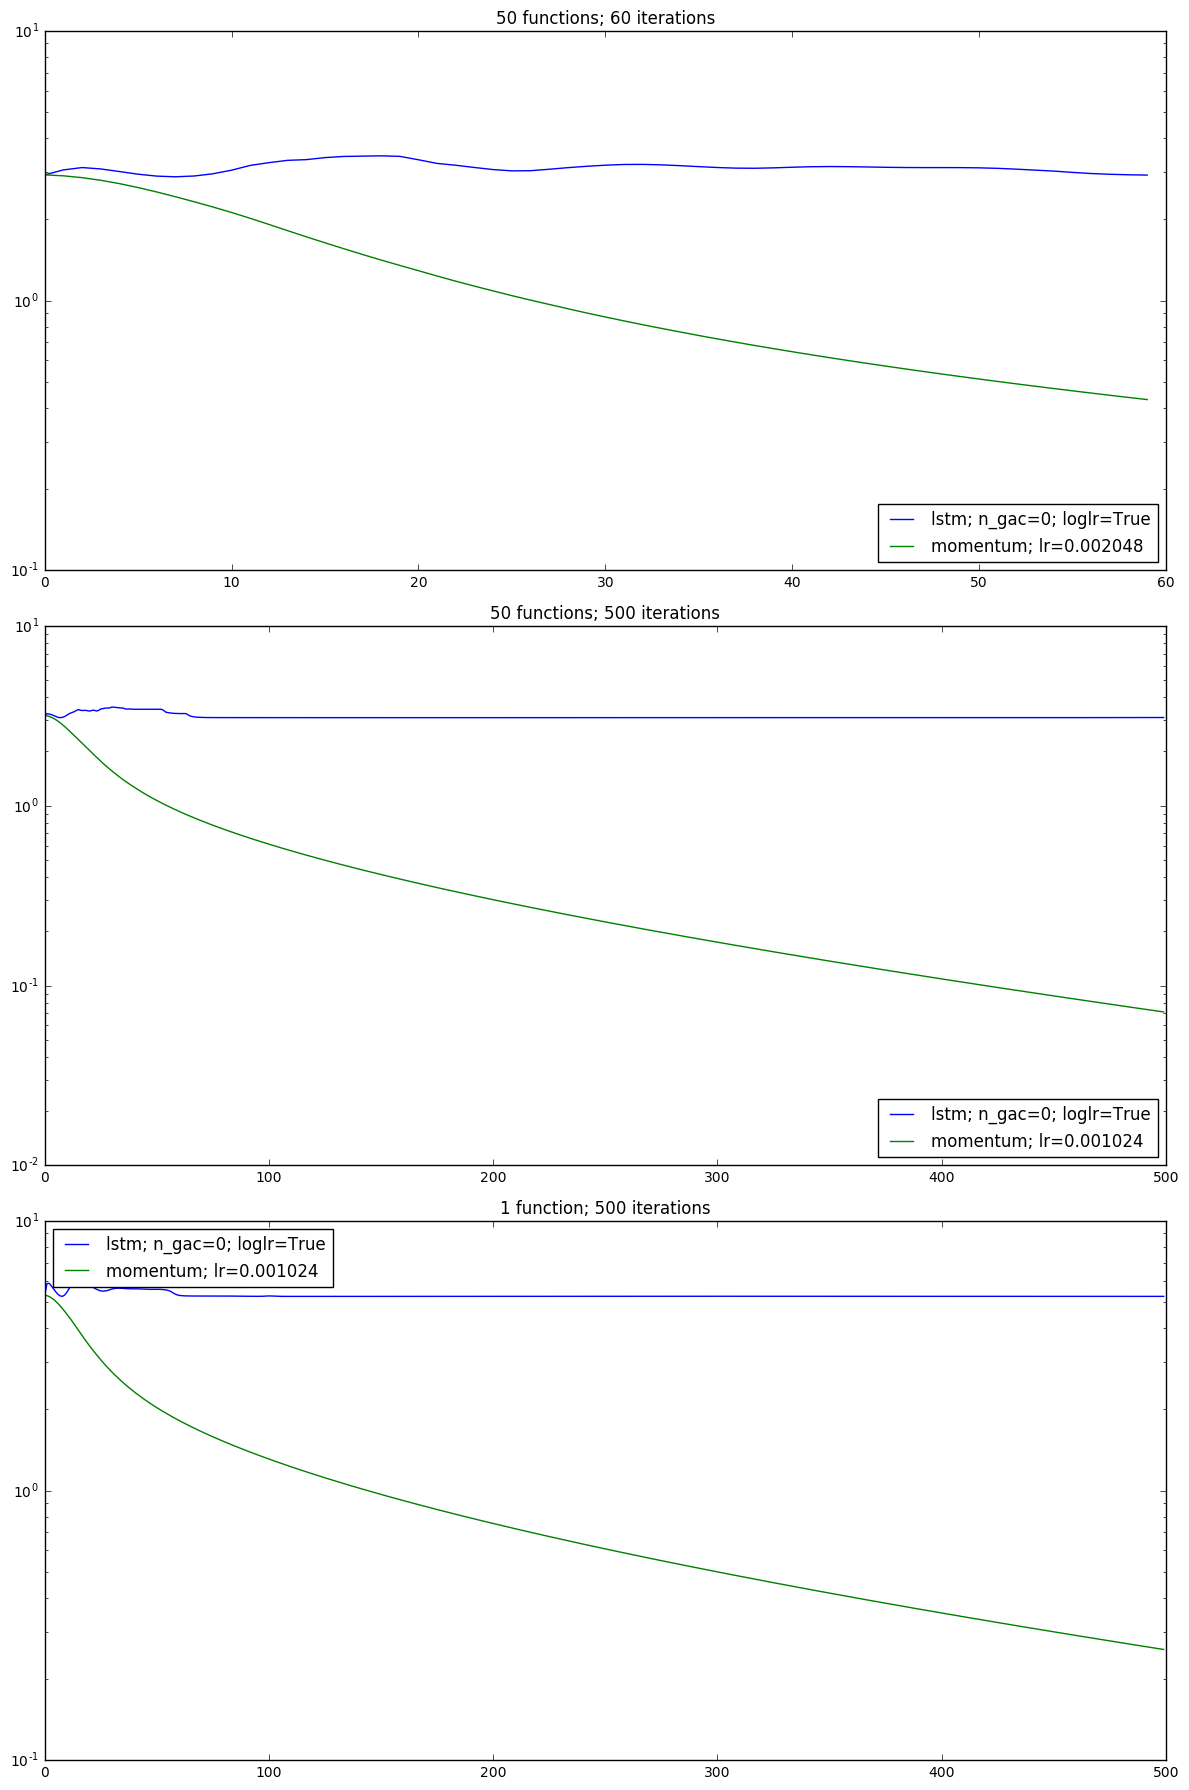

In [35]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))

for name in sorted(set(list(histories_60.keys()) + list(histories_500.keys()) + list(histories_1_func.keys()))):
    if name.find('det') != -1:
        continue
    if name.find('False') == -1:
        linestyle = 'solid'
    else:
        linestyle = '--'
        
    if histories_60.get(name) is not None:
        ax1.semilogy(histories_60[name], label=name, linestyle=linestyle)
    if histories_500.get(name) is not None:
        ax2.semilogy(histories_500[name], label=name, linestyle=linestyle)
    if histories_1_func.get(name) is not None:
        ax3.semilogy(histories_1_func[name], label=name, linestyle=linestyle)
    
# fig.legend(loc=4);
ax1.set_title('50 functions; 60 iterations')
ax2.set_title('50 functions; 500 iterations')
ax3.set_title('1 function; 500 iterations')
ax1.legend(loc=4)
ax2.legend(loc=4)
ax3.legend(loc=2)
fig.tight_layout()

In [36]:
theta, (a_, b_) = sample_point_and_params(ndim=2)

sample_runs = {}

for name, opt in lstm_optimizers.items():
    history, losses = opt.optimize(theta, [a_, b_], 100)
    history = np.concatenate([theta.reshape(1, -1), history], axis=0)
    sample_runs[name] = (history, losses)
    
#     history, losses = opt.loss_det_fn(theta, 100, W_, b_)
#     history = np.concatenate([theta.reshape(1, -1), history], axis=0)
#     sample_runs[name+'_det'] = (history, losses)


sample_runs['momentum'] = momentum_fn(theta, 100, a_, b_, 0.001)

(-1.785258685366892, 3.187148573677923)


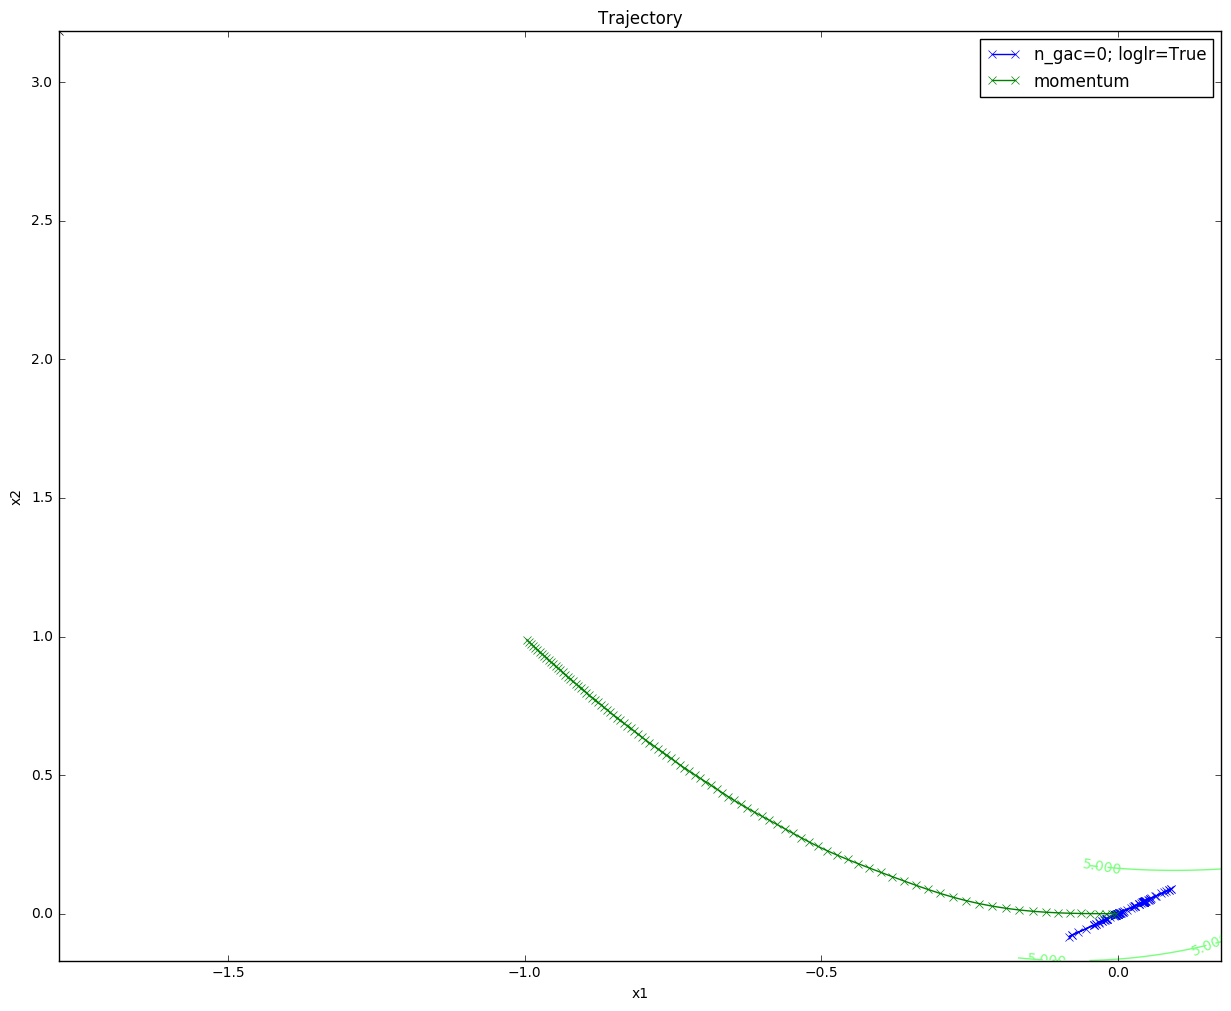

In [37]:
# theta_opt = np.linalg.pinv(W_).dot(b_)
theta_opt = (a_, a_**2)

min_x = min(sample_runs[list(lstm_optimizers.keys())[0]][0].T[0])
max_x = max(sample_runs[list(lstm_optimizers.keys())[0]][0].T[0])
min_y = min(sample_runs[list(lstm_optimizers.keys())[0]][0].T[1])
max_y = max(sample_runs[list(lstm_optimizers.keys())[0]][0].T[1])

delta_x = (max_x - min_x) / 100.
delta_y = (max_y - min_y) / 100.

x = np.arange(2 * min_x - (min_x + max_x) / 2, 2 * max_x - (min_x + max_x) / 2, delta_x)
y = np.arange(2 * min_y - (min_y + max_y) / 2, 2 * max_y - (min_y + max_y) / 2, delta_y)
X, Y = np.meshgrid(x, y)

# Z = np.zeros(X.shape)
# for i in range(X.shape[0]):
#     for j in range(X.shape[1]):
#         z = ((W_.dot(np.array([X[i][j], Y[i][j]])) - b_)**2).sum()
#         Z[i][j] = z

Z = (a_ - X)**2 + b_ * (Y - X**2)**2
        
plt.figure(figsize=(15, 12))
plt.title('Trajectory')

CS = plt.contour(X, Y, Z, levels=[1e-4, 1e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1e-0, 5e-0, 1e1])
plt.clabel(CS, inline=1, fontsize=10)

plt.xlabel('x1')
plt.ylabel('x2')

for name in sample_runs:
    history, lss = sample_runs[name]
#     if lss[-1] > 0.1:
#         continue
    linestyle = 'solid'
#     if name.find('0.0') != -1 and name.find('det') != -1:
#         continue
#     if name.find('det') == -1:
#         linestyle = 'solid'
#     elif name.find('fix=False') != -1:
#         linestyle = '-.'
#     else:
#         linestyle = '--'
    plt.plot(history.T[0], history.T[1], linestyle=linestyle, label=name, marker='x')

# history, _ = sample_runs['momentum']
# plt.plot(np.array(history).T[0], np.array(history).T[1], label='momentum', marker='o', linestyle='--')

print(theta_opt)
plt.plot([theta_opt[0]], [theta_opt[1]], marker='x', color='k')            
plt.legend();

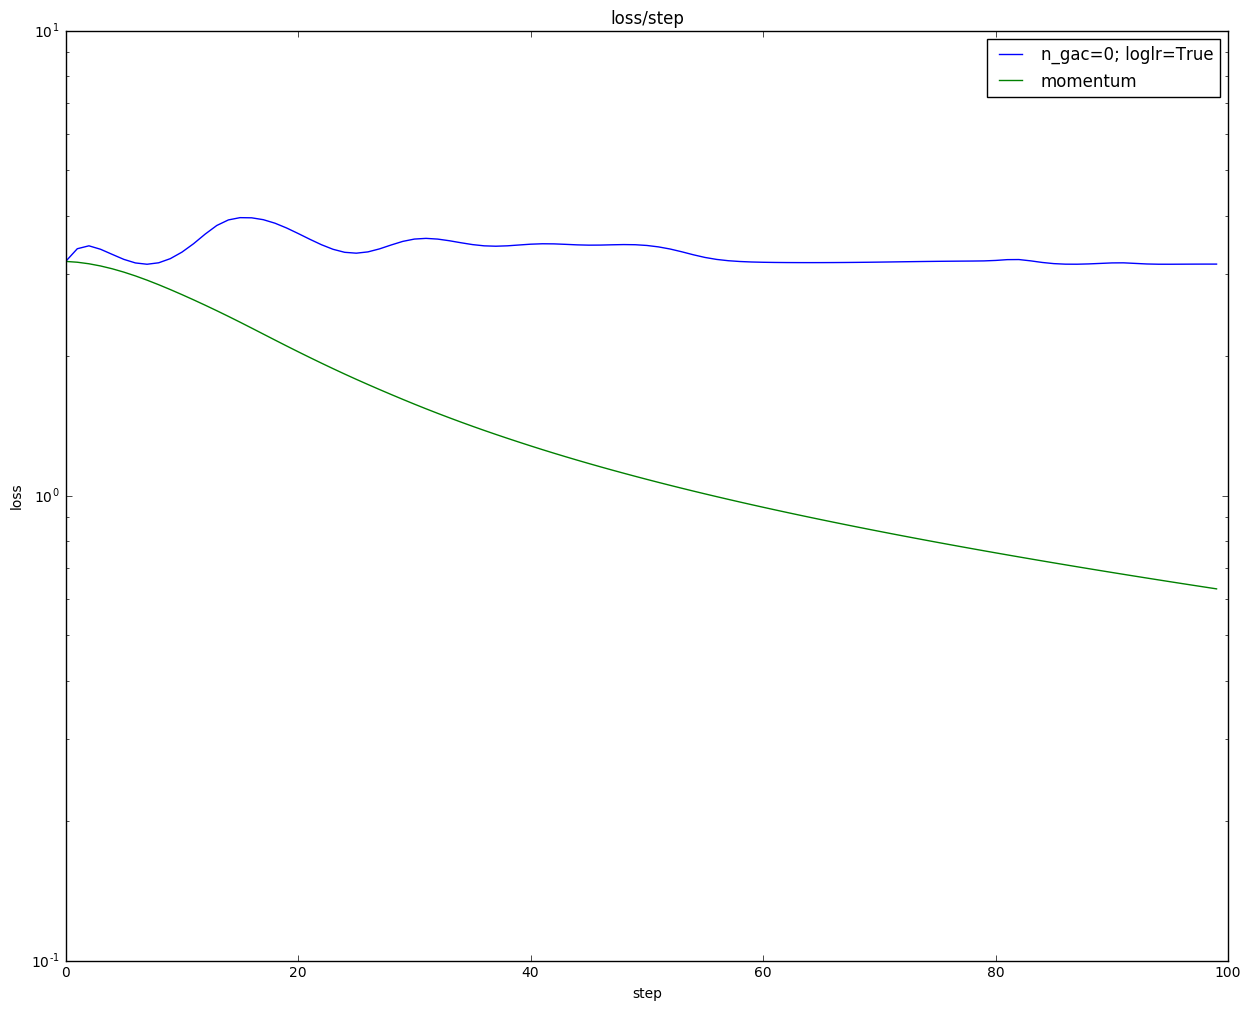

In [38]:
plt.figure(figsize=(15, 12))
plt.title('loss/step')
plt.xlabel('step')
plt.ylabel('loss')

for name in sample_runs:
    _, losses = sample_runs[name]
    plt.semilogy(losses, label=name, linestyle=linestyle)

# _, losses = sample_runs['momentum']    
# plt.semilogy(losses, label='momentum', linestyle='--')
plt.legend();